**About** : This notebook is used to train models.


In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/home/theo/Documents/sartorius/src


## Initialization

### Imports

In [3]:
import os
import sys
import cv2
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
warnings.simplefilter("ignore", UserWarning)

In [4]:
from params import *

from utils.plots import *
from utils.metrics import iou_map
from utils.rle import rles_to_mask_fix
from utils.logger import prepare_log_folder, create_logger, save_config

from data.preparation import prepare_data
from data.transforms import get_transfos, get_transfos_inference
from data.dataset import SartoriusDataset

from training.main import k_fold
from inference.post_process import *

2021-12-06 20:13:33,730 [INFO] WRITING LOG OUTPUT TO /home/theo/.cellpose/run.log


## Data

In [5]:
df = prepare_data()

In [6]:
dataset_plot = SartoriusDataset(df)


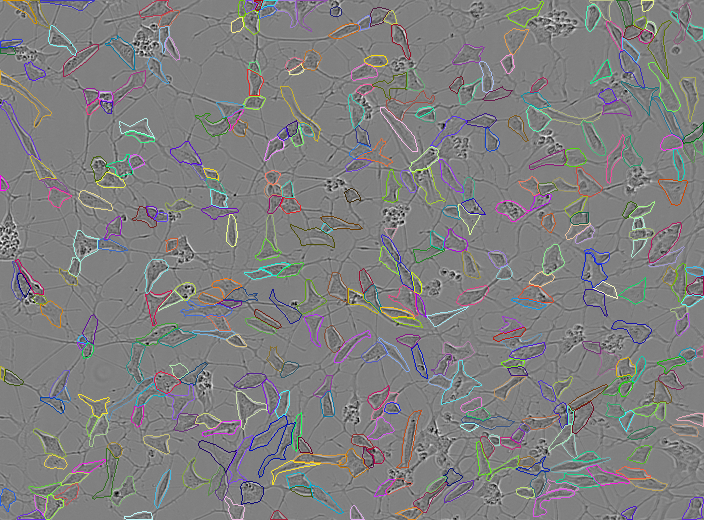

In [7]:
idx = 0

img, masks, y = dataset_plot[idx]

mask = masks[..., 0]
fig = plot_sample(img, mask, plotly=True)

fig.update_layout(
    autosize=False,
    width=900,
    height=800,
)

fig.show()

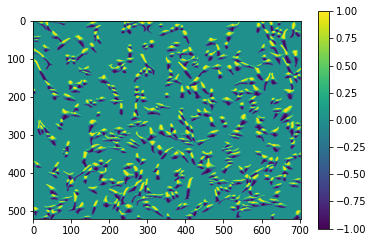

In [8]:
plt.imshow(masks[..., 1])
plt.colorbar()

In [9]:
transforms = get_transfos(augment=True, visualize=True)
dataset = SartoriusDataset(df, transforms=transforms)

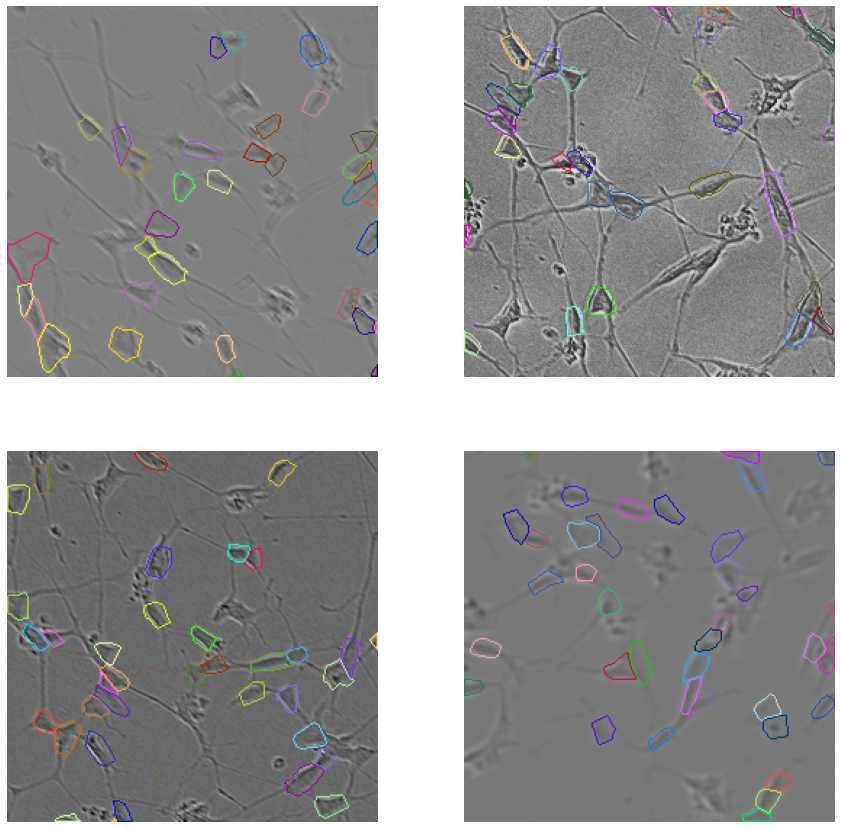

In [10]:
plt.figure(figsize=(15, 15))

for i in range(4):
    plt.subplot(2, 2, i + 1)
#     idx = np.random.choice(len(dataset))
    idx = 188
    img, masks, y = dataset[idx]

    try:
        img = img.numpy().transpose(1, 2, 0)
        mask = masks[0].numpy().astype(int)
        plot_sample(img, mask)
    except AttributeError:
        plot_sample(img, mask)

    plt.axis(False)
plt.show()

## Model

In [11]:
from model_zoo.models import define_model
from training.optim import SartoriusLoss

In [12]:
model = define_model(
    "Unet",
    "resnet18",
    num_classes=3,
    num_classes_cls=0,
    encoder_weights="imagenet",
    reduce_stride=True
)

In [13]:
x = torch.rand(1, 3, 256, 256)
pred_mask, pred_cls = model(x)

pred_mask.size(), pred_cls.size()

(torch.Size([1, 3, 256, 256]), torch.Size([1, 0]))

In [14]:
cfg = {"w_bce": 1, "w_lovasz": 0, "w_seg_loss": 1}
loss = SartoriusLoss(cfg)

In [15]:
img, y_mask, y_cls = dataset[0]

In [16]:
loss(pred_mask, pred_cls, y_mask.unsqueeze(0).float(), y_cls.unsqueeze(0).float())

tensor([2.7159], grad_fn=<AddBackward0>)

## Training

In [17]:
BATCH_SIZES = {
    "resnet18": 32,
    "resnet34": 32,
    "resnext50_32x4d": 32,
    "se_resnext50_32x4d": 32,
    "efficientnet-b0": 32,
    "efficientnet-b1": 32,
    "efficientnet-b2": 32,
    "efficientnet-b3": 16,
    "efficientnet-b4": 16,
    "efficientnet-b5": 16,
    "efficientnet-b6": 8,
}

In [18]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    first_epoch_eval = 0

    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # Images
    size = 256
    size_val = 512
    use_tta = True
    width = 2

    # k-fold
    k = 5
    random_state = 0
    selected_folds = [0, 1, 2, 3, 4]

    # Model
    encoder = "resnext50_32x4d"  # "resnet18" "resnext50_32x4d", "resnet34", "efficientnet-b5"
    decoder = "Unet"
    encoder_weights = "imagenet"
    num_classes = 3
    num_classes_cls = 3
    reduce_stride = False  # True

    # Training
    activations = {
        "cls": "softmax", 
        "mask": "sigmoid",
        "dist": None,
    }

    optimizer = "Adam"
    loss_config = {
        "w_bce": 1,
        "w_lovasz": 0,
        "w_seg_loss": 1,
    }

    batch_size = BATCH_SIZES[encoder]
    val_bs = batch_size

    if reduce_stride:
        batch_size = batch_size // 2
        val_bs = batch_size // 2

    epochs = 30  # 40 if batch_size >= 32 else 30

    lr = 1e-3
    warmup_prop = 0.05

In [19]:
DEBUG = True
log_folder = None

In [20]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    config_df = save_config(Config, log_folder + "config.json")
    create_logger(directory=lµog_folder, name="logs.txt")

preds, preds_instance, truths = k_fold(Config, log_folder=log_folder)


-------------   Fold 1 / 5  -------------

    -> 484 training images
    -> 122 validation images
    -> 31999414 trainable parameters

Epoch 01/40 	 lr=5.0e-04	 t=9s	loss=1.153	val_loss=7.005 	 dice=0.165 	acc=0.508
Epoch 02/40 	 lr=1.0e-03	 t=8s	loss=1.062	val_loss=1.081 	 dice=0.323 	acc=0.648
Epoch 03/40 	 lr=9.7e-04	 t=8s	loss=0.962	val_loss=0.928 	 dice=0.289 	acc=0.467
Epoch 04/40 	 lr=9.5e-04	 t=8s	loss=0.948	val_loss=0.918 	 dice=0.604 	acc=0.557
Epoch 05/40 	 lr=9.2e-04	 t=8s	loss=0.935	val_loss=0.912 	 dice=0.466 	acc=0.664
Epoch 06/40 	 lr=8.9e-04	 t=8s	loss=0.932	val_loss=0.909 	 dice=0.597 	acc=0.525
Epoch 07/40 	 lr=8.7e-04	 t=8s	loss=0.942	val_loss=0.909 	 dice=0.703 	acc=0.525
Epoch 08/40 	 lr=8.4e-04	 t=8s	loss=0.932	val_loss=0.901 	 dice=0.676 	acc=0.508
Epoch 09/40 	 lr=8.2e-04	 t=8s	loss=0.892	val_loss=0.916 	 dice=0.631 	acc=0.590
Epoch 10/40 	 lr=7.9e-04	 t=8s	loss=0.912	val_loss=0.913 	 dice=0.731 	acc=0.648
Epoch 11/40 	 lr=7.6e-04	 t=8s	loss=0.925	val_loss=0

## Viz

In [21]:
config = Config

skf = StratifiedKFold(n_splits=config.k, shuffle=True, random_state=config.random_state)
splits = list(skf.split(X=df, y=df["cell_type"]))

all_preds, all_truths = [], []

for i, (train_idx, val_idx) in enumerate(splits):
    if i in config.selected_folds:
        df_val = df.iloc[val_idx].copy().reset_index(drop=True)
        dataset = SartoriusDataset(df_val, transforms=None)
        break

In [22]:
PLOT = True

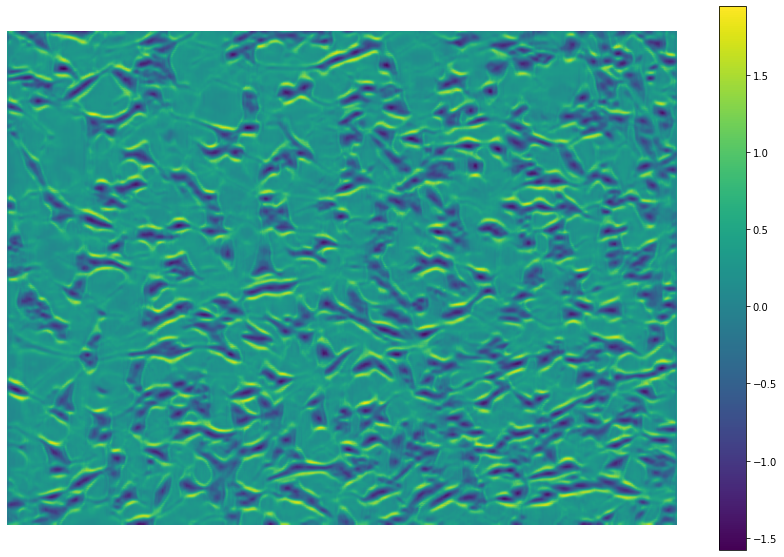

In [29]:
plt.figure(figsize=(15, 10))
plt.imshow(pred[1])
# plt.imshow(dataset[0][1][..., 1])
plt.colorbar()
plt.axis(False)
plt.show()

In [25]:
new_preds_i = []
scores = []
types = []

for i, (pred, truth) in tqdm(enumerate(zip(preds, truths))):
    cell_type = df_val['cell_type'][i]
    
    gt = dataset[i][1].transpose(2, 0, 1)
    
#     pred = pred.transpose(1, 2, 0)
#     pred[[..., 1:] = gt[..., 1:]

    break
    
    pred = np.array(pred)
    if cell_type == "shsy5y":
#         continue
        pred_i2 = post_process_shsy5y(pred)
        pred_i2 = remove_small_components(pred_i2, 100, 0)
        
    
    elif cell_type == "cort":
#         continue
        pred_i2 = post_process_cort(pred)
        pred_i2 = remove_small_components(pred_i2, 50, 0)
            
    else:
        pred_i2 = post_process_astro(pred)
        pred_i2 = remove_small_components(pred_i2, 300, 0)
    
    new_preds_i.append(pred_i2)
    
    score = iou_map([truth], [pred_i2], verbose=0)

    scores.append(score)
    types.append(cell_type)
    
    if PLOT:
        img, _, _ = dataset[i]

#         plt.figure(figsize=(15, 15))
#         plot_sample(img, truth)
#         plt.axis(False)
#         plt.title(f'Truth - {cell_type}')
#         plt.show()

        plt.figure(figsize=(15, 15))
        plot_sample(img, pred_i2)
        plt.axis(False)
        plt.title(f'Pred - map_iou= {score:.3f}')
        plt.show()

#         if i > 10:
        break

In [ ]:
fig = plot_preds_iou(img, pred_i2, truth)

fig.update_layout(
    autosize=False,
    width=900,
    height=700,
)

fig.show()

In [ ]:
types = np.array(types)
scores = np.array(scores)

for t in np.unique(types):
    print(f'Avg score for {t} : {np.mean(scores[types == t]) :.3f}')